# Multivariate Distributions

Import necessary modules:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
from tqdm.auto import tqdm
import matplotlib as mpl
import pymc as pm

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

import os
os.environ['PYTENSOR_FLAGS'] = 'cxx='

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

## Foundry example

In [3]:
observations = [1055, 1053, 1226,  967,  980, 1049, 1040, 1051, 1002, 1057]

with pm.Model() as normal_normal_model:
    mu = pm.Normal( 'mu', mu=1000, sigma=100 )
    sigma = pm.Exponential( 'sigma', 1/100 )
    y = pm.Normal( 'y', mu=mu, sigma=sigma, observed=observations )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

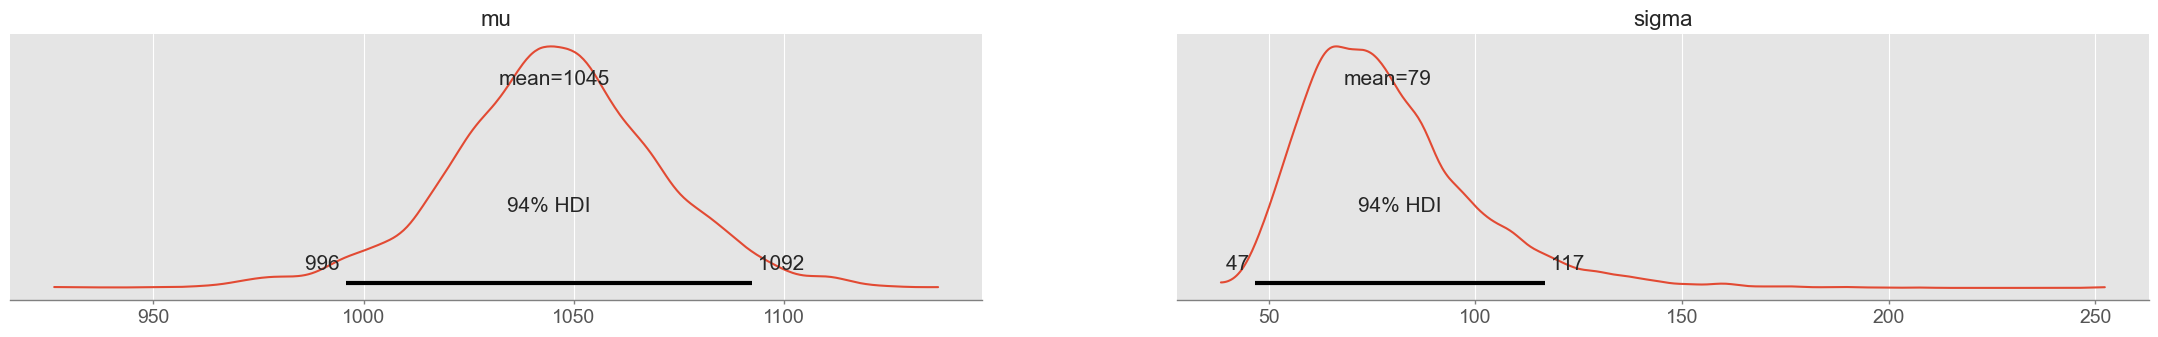

In [4]:
pm.plot_posterior( trace )

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

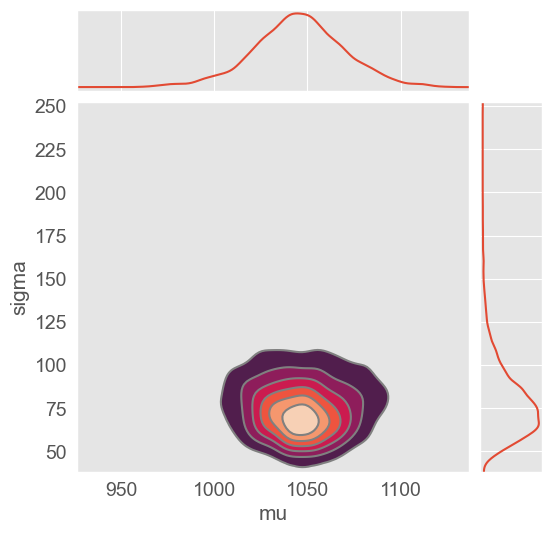

In [5]:
pm.plot_pair( trace, var_names=['mu', 'sigma'], kind='kde', marginals=True, figsize=(6,6) )

## Covariance and correlation

### Covariance and correlation for the Foundry posterior

Use Pandas:

In [6]:
trace_df = pd.DataFrame( {
    'mu': trace.posterior.mu.values.flatten(), 
    'sigma': trace.posterior.sigma.values.flatten() 
} )
trace_df.cov()

,mu,sigma
mu,627.655061,-30.689092
sigma,-30.689092,440.532675


In [7]:
trace_df.corr()

,mu,sigma
mu,1.000000,-0.058363
sigma,-0.058363,1.000000


$\mu$ and $\sigma$ are practically uncorrelated in the posterior! (as the contour plot above already suggested)

### Credit card dataset example

In [8]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [9]:
credit_data[['Rating', 'Age', 'Income', 'Limit']].cov()

,Rating,Age,Income,Limit
Rating,23939.560301,275.343409,4315.492940,3.560197e+05
Age,275.343409,297.555833,106.598192,4.016952e+03
Income,4315.492940,106.598192,1242.158791,6.443701e+04
Limit,356019.735338,4016.951880,64437.012874,5.327782e+06


In [10]:
credit_data[['Rating', 'Age', 'Income', 'Limit']].corr()

,Rating,Age,Income,Limit
Rating,1.000000,0.103165,0.791378,0.996880
Age,0.103165,1.000000,0.175338,0.100888
Income,0.791378,0.175338,1.000000,0.792088
Limit,0.996880,0.100888,0.792088,1.000000


Extremely high correlation between Rating and Limit, very high correlation between Income and Limit.

### Computation with linear algebra

In [11]:
X = credit_data[['Rating', 'Age', 'Income', 'Limit']].values
X2 = X - np.mean(X, axis=0)
C = 1/(X.shape[0]-1) * X2.T @ X2
np.round( C, 2 )

array([[2.39395600e+04, 2.75340000e+02, 4.31549000e+03, 3.56019740e+05],
       [2.75340000e+02, 2.97560000e+02, 1.06600000e+02, 4.01695000e+03],
       [4.31549000e+03, 1.06600000e+02, 1.24216000e+03, 6.44370100e+04],
       [3.56019740e+05, 4.01695000e+03, 6.44370100e+04, 5.32778192e+06]])

In [12]:
R = C * 1/np.sqrt( np.outer( np.diag( C ), np.diag( C ) ) )
np.round( R, 5 )

array([[1.     , 0.10316, 0.79138, 0.99688],
       [0.10316, 1.     , 0.17534, 0.10089],
       [0.79138, 0.17534, 1.     , 0.79209],
       [0.99688, 0.10089, 0.79209, 1.     ]])

Very similar values as computed with Pandas!

## Multinomial Problem

### Dirichlet prior

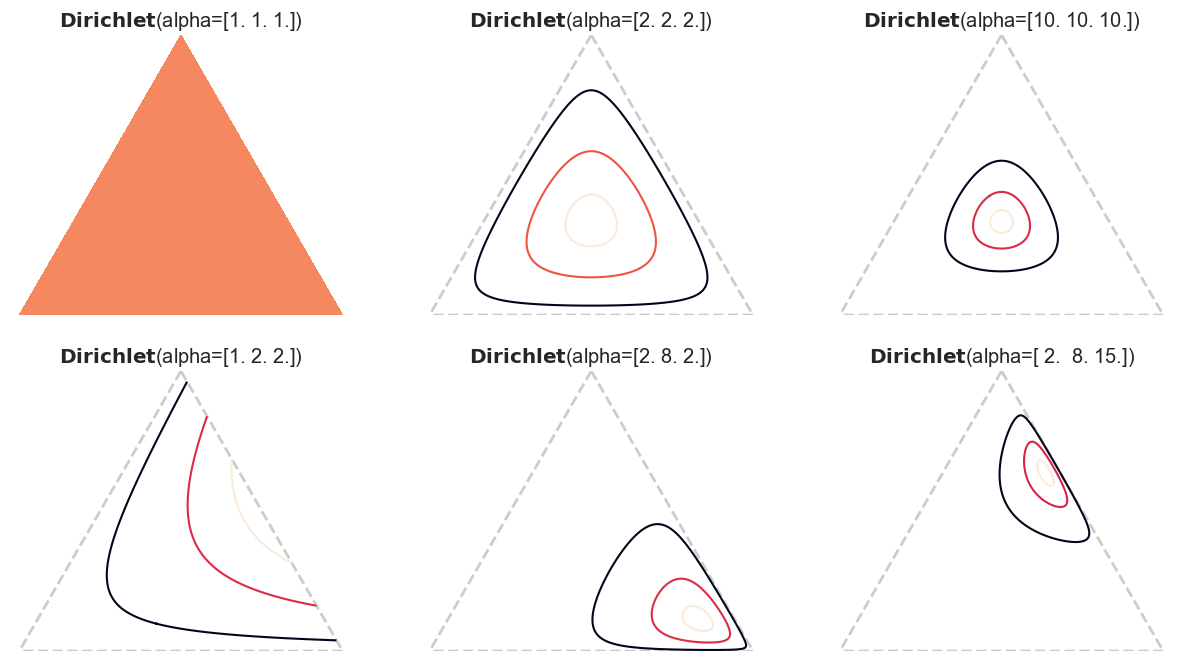

In [13]:
fig, ax = plt.subplots( 2, 3, figsize=(15,8) )
pz.Dirichlet( alpha=[1,1,1] ).plot_pdf( marginals=False, ax=ax[0,0] )
pz.Dirichlet( alpha=[2,2,2] ).plot_pdf( marginals=False, ax=ax[0,1] )
pz.Dirichlet( alpha=[10,10,10] ).plot_pdf( marginals=False, ax=ax[0,2] )
pz.Dirichlet( alpha=[1,2,2] ).plot_pdf( marginals=False, ax=ax[1,0] )
pz.Dirichlet( alpha=[2,8,2] ).plot_pdf( marginals=False, ax=ax[1,1] )
pz.Dirichlet( alpha=[2,8,15] ).plot_pdf( marginals=False, ax=ax[1,2] )

### Simulate multinomial model with flat Dirichlet prior

In [14]:
with pm.Model() as election_model:
    pi = pm.Dirichlet( 'pi', a=[1,1,1] )
    y = pm.Multinomial( 'y', n=40, p=pi, observed=[7,22,11] )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


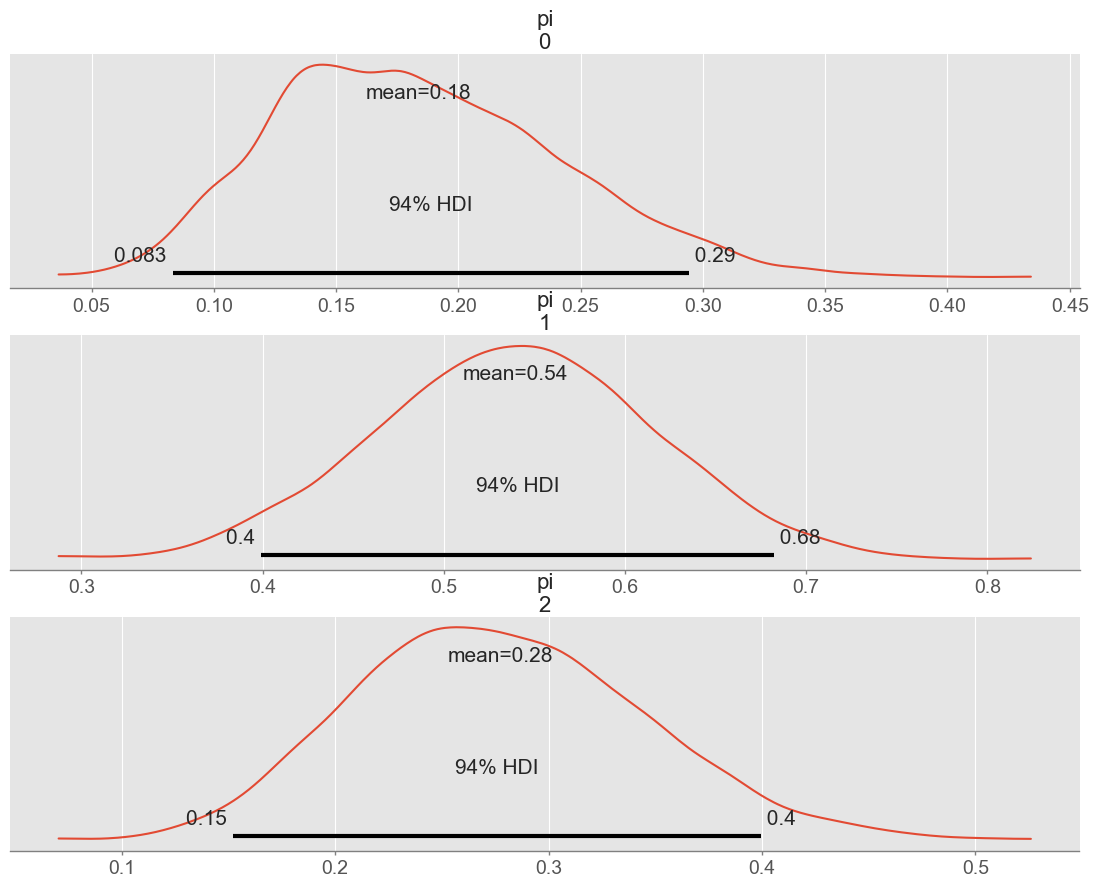

In [15]:
pm.plot_posterior( trace, grid=(3,1) );

All in one:

<Axes: ylabel='Density'>

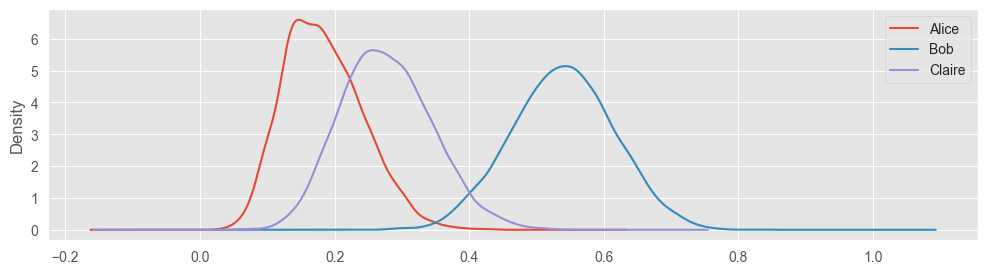

In [16]:
pi_samples = trace.posterior.pi.values.reshape(-1,3)
df = pd.DataFrame( pi_samples )
df.columns = ["Alice", "Bob", "Claire"]
df.plot.kde()

Our posterior belief that Bob wins the elections is very large! We can quantify P(Bob wins|data) using our samples:

In [17]:
np.mean( np.all( pi_samples[:,[0,2]] < pi_samples[:,1].reshape(-1,1), axis=1 ) )

0.9705

We believe it to >96%!

### Using Dirichlet-Multinomial conjugate family for plot of joint density

In [18]:
alpha = np.array([1,1,1])
k = np.array([7,22,11])
pz.Dirichlet( alpha=alpha+k ).plot_pdf( marginals=False, legend=False )
plt.text(1, -0.10, "Bob", fontsize=20)
plt.text(0.35, 0.9, "Claire", fontsize=20)
plt.text(-0.25, -0.1, "Alice", fontsize=20)

TypeError: plot_pdf() got an unexpected keyword argument 'legend'

In [19]:
pz.Dirichlet( alpha=alpha+k ).summary()

Dirichlet(mean=array([0.18604651, 0.53488372, 0.27906977]), std=array([0.0586657 , 0.07519416, 0.06762024]))

## Multivariate Normal Distribution

### 3D plot of bivariate normal

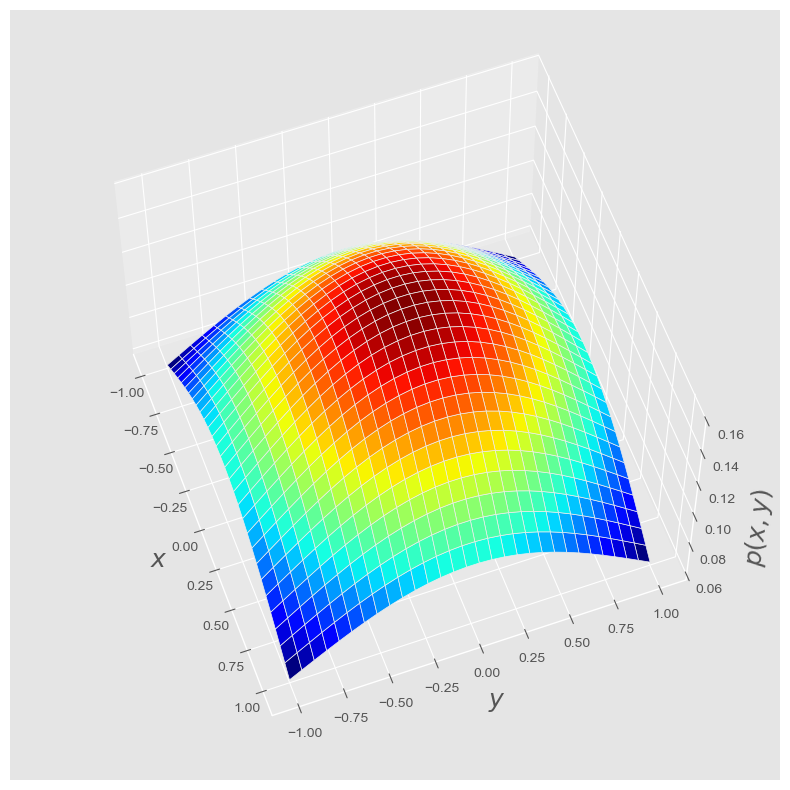

In [20]:
from mpl_toolkits.mplot3d import Axes3D

def plot_mvnormal_3d( mu, cov, xrange=[-1,1], yrange=[-1,1] ):
    x, y = np.mgrid[xrange[0]:xrange[1]:30j, yrange[0]:yrange[1]:30j]
    xy = np.column_stack([x.flat, y.flat])
    z = stats.multivariate_normal.pdf(xy, mean=mu, cov=cov)
    z = z.reshape(x.shape)

    fig = plt.figure( figsize=(8,8) )
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z, cmap="jet")
    ax.set_xlabel("$x$", fontsize=18, labelpad=10)
    ax.set_ylabel("$y$", fontsize=18, labelpad=10)
    ax.set_zlabel("$p(x, y)$", fontsize=18, labelpad=10)
    
    ax.set_box_aspect(aspect=None, zoom=0.9)
    ax.view_init(elev=60., azim=-20)
    plt.tight_layout()


plot_mvnormal_3d( mu=[0,0], cov=[[1,0],[0,1]] )

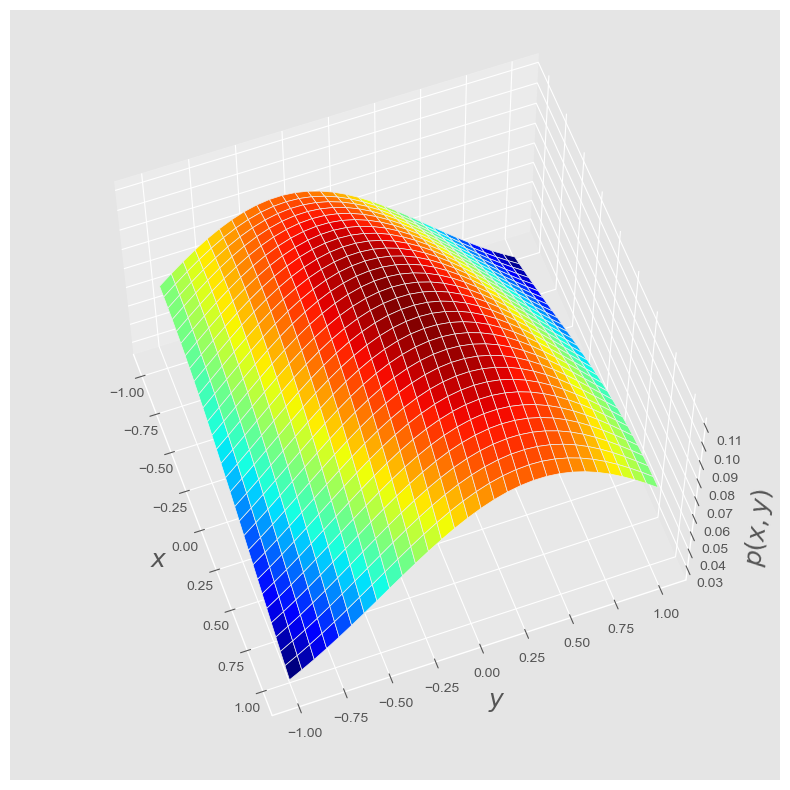

In [21]:
plot_mvnormal_3d( mu=[0,0], cov=[[3,1],[1,1]] )

### Contour plot of bivariate normal

In [22]:
def plot_mvnormal( mu, cov, xrange=[-3,3], yrange=[-3,3], ax=None ):
    
    # setup grid
    x = np.linspace(xrange[0], xrange[1], 1000)
    y = np.linspace(yrange[0], yrange[1], 1000)
    X, Y = np.meshgrid(x, y)

    # multivariate normal
    Z = stats.multivariate_normal( mean=mu, cov=cov ).pdf( np.dstack((X, Y)) )

    # create plot
    if ax is not None:
        plt.sca(ax)

    CS = plt.contour(X, Y, Z, levels=20)
    plt.gca().set_aspect("equal");

Text(0, 0.5, 'y')

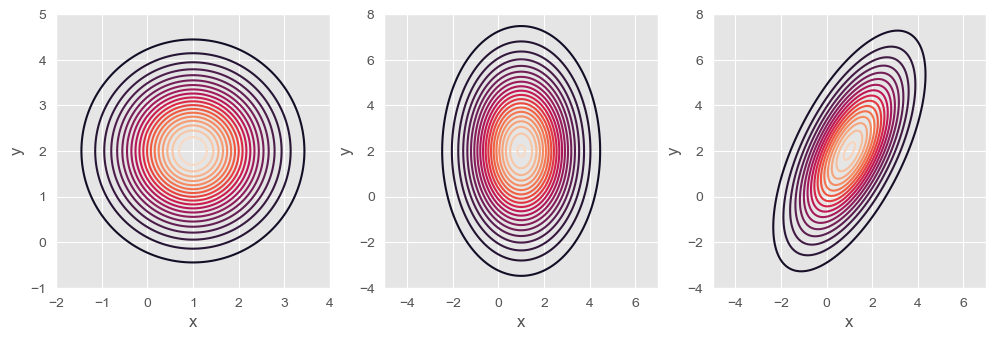

In [23]:
fig, ax = plt.subplots( 1, 3, figsize=(12,4) )

Sigma1 = [[1,0],[0,1]]
Sigma2 = [[2,0],[0,5]]
Sigma3 = [[2,2],[2,5]]

plot_mvnormal( mu=[1,2], cov=Sigma1, ax=ax[0], xrange=[-2,4], yrange=[-1,5] )
ax[0].set_title("")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

plot_mvnormal( mu=[1,2], cov=Sigma2, ax=ax[1], xrange=[-5,7], yrange=[-4,8] )
ax[1].set_title("")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

plot_mvnormal( mu=[1,2], cov=Sigma3, ax=ax[2], xrange=[-5,7], yrange=[-4,8] )
ax[2].set_title("")
ax[2].set_xlabel("x")
ax[2].set_ylabel("y")

With PreliZ:

<Axes: title={'center': '$\\bf{MvNormal}$(mu=[1. 2.],cov=[[2. 2.]\n [2. 5.]])'}>

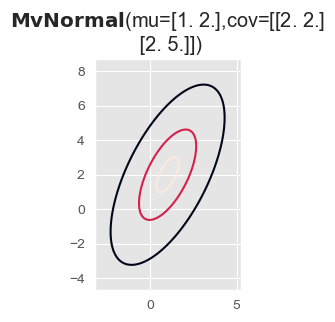

In [24]:
pz.MvNormal( mu=[1,2], cov=Sigma3 ).plot_pdf( marginals=False )

### <font color="red">Optional</font> Application: Bayesian Covariance Estimation (on credit card dataset)

Read data:

In [25]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Select only Income and Rating:

In [26]:
credit_data = credit_data[['Income', 'Rating']]
credit_data

,Income,Rating
0,14.891,283
1,106.025,483
2,104.593,514
3,148.924,681
4,55.882,357
...,...,...
395,12.096,307
396,13.364,296
397,57.872,321
398,37.728,192


Contour density plot:

<Axes: xlabel='Income', ylabel='Rating'>

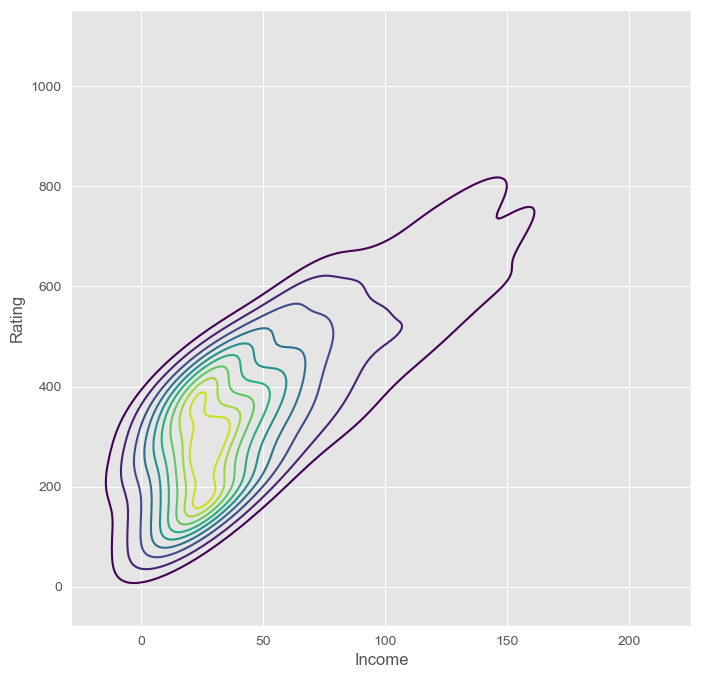

In [27]:
plt.figure( figsize=(8,8) )
sns.kdeplot( data=credit_data, x="Income", y="Rating", cmap="viridis" )

Standardize data (can always transform back at the end):

In [28]:
means = credit_data.mean()
stds = credit_data.std()
credit_data = (credit_data - means) / stds

In [29]:
credit_data.agg(['mean', 'std']).round(10)

,Income,Rating
mean,-0.0,0.0
std,1.0,1.0


<Axes: xlabel='Income', ylabel='Rating'>

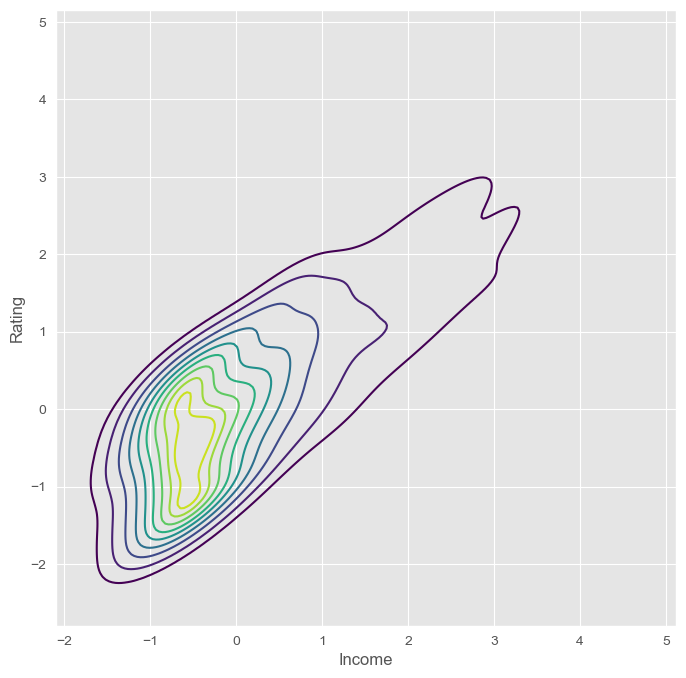

In [30]:
plt.figure( figsize=(8,8) )
sns.kdeplot( data=credit_data, x="Income", y="Rating", cmap="viridis" )

Fit a model with multivariate normal likelihood, LKJ prior for covariance and multivariate normal prior for mean:

In [31]:
with pm.Model() as mv_normal_model:
    # Prior for the mean (should be around zero!) - assume a lot of (symmetric) covariance
    mean = pm.MvNormal('mean', mu=0, cov=[[1,0],[0,1]] )

    # Prior for standard deviations (to rescale the correlation matrix to the covariance matrix)
    sigma_dist = pm.Exponential.dist(1)

    # Prior for the correlation matrix (flat for eta=1, estimating cov through Cholesky decomposition)
    chol, corr, sigmas = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sigma_dist)
    cov = chol.dot(chol.T)
    cov = pm.Deterministic('cov', cov) # store as variable for later access
    
    # Define the multivariate normal distribution
    y_pred = pm.MvNormal('y_pred', mu=mean, cov=cov, observed=credit_data[['Income', 'Rating']].values)

    # Perform Bayesian inference 
    # (warm-up phase reduced to 1000 steps, increase the target_accept rate for nuts for better stability)
    trace = pm.sample(draws=2000, chains=4, tune=1000, nuts={'target_accept': 0.95})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, chol_cov]


Output()

/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/pytensor/scalar/basic.py:2094: RuntimeWarning: divide by zero encountered in divide
  return x / y
/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/pytensor/scalar/basic.py:3023: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/marbetschar/miniconda3/envs/bayesianmachinelearning/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: invalid value encountered i

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 87 seconds.


Plot trace for mean and covariance values (looks good):

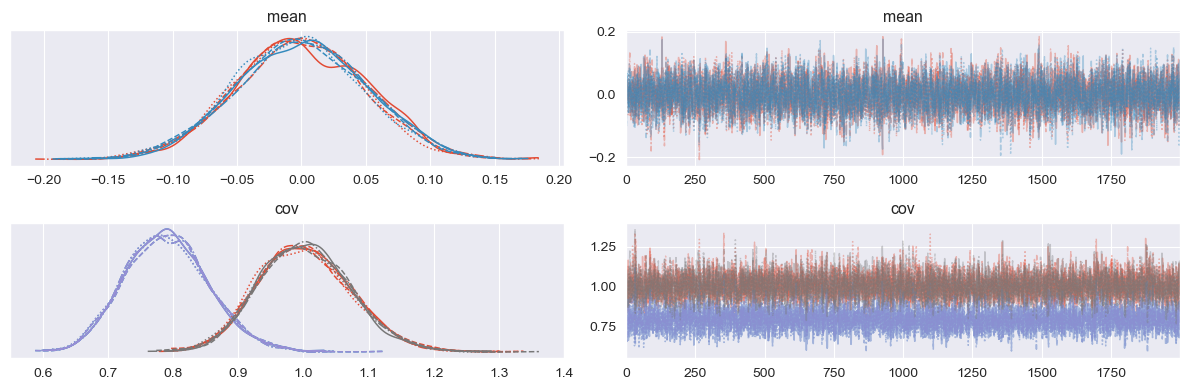

In [32]:
pm.plot_trace( trace, var_names=["mean", "cov"] )
plt.tight_layout()

**Careful:** Both plots show the evolution of the two means (different colors, zero because of standardization) and the two covariance values (because we standardized the data, covariance is equal to correlation, simulation estimated diagonals (1.0) and off-diagonals ($\rho$, identical) of the 2x2 matrix).